# Kids Game Classification with NLP

*by [Marina Villaschi](https://www.linkedin.com/in/marinavillaschi)*

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(2018)

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS, remove_stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier

# setting seed for project
seed = 2018

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [10]:
# read scrapped review data
df= pd.read_csv('/content/drive/MyDrive/NLP Omdena/game_reviews - game_reviews.csv')
df.shape

(561, 3)

In [12]:
df.head()

,author age,recommended age,review
0,"Teen, 17 years old",age 7+,Kids dont listent to the parents saying ''ThIs...
1,"Kid, 11 years old",age 2+,I have been playing this game for many years a...
2,"Kid, 12 years old",age 7+,The game is great with no true inappropriate t...
3,"Teen, 13 years old",age 5+,Are you sure you got common sense. I would giv...
4,"Kid, 10 years old",age 5+,IDK WHAT TO SAY BUT DIS IS DA BEST GAME EVA


In [17]:
df.dtypes

author age         object
recommended age    object
review             object
dtype: object

## Step 1 - Labeling data

In [18]:
df['recommended age'] = df['recommended age'].str.replace("age ","")
df['recommended age'] = df['recommended age'].str.replace("+","")
df['recommended age'] = df['recommended age'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  


In [20]:
# checking the types of columns
df.dtypes

author age         object
recommended age     int64
review             object
dtype: object

In [21]:
# great! now our recommended age column is int and we can finally make a label column based on it
# creating a label column where 1 is suitable for kids (less than 10yo) and 0 is not suitable (ok for kids 10+)
df['label'] = np.where(df['recommended age'] <10 , 1, 0)

In [33]:
# making sure we only get the non na reviews rows for the final dataset
df = df[~df.review.isna()]
df

,author age,recommended age,review,label
0,"Teen, 17 years old",7,Kids dont listent to the parents saying ''ThIs...,1
1,"Kid, 11 years old",2,I have been playing this game for many years a...,1
2,"Kid, 12 years old",7,The game is great with no true inappropriate t...,1
3,"Teen, 13 years old",5,Are you sure you got common sense. I would giv...,1
4,"Kid, 10 years old",5,IDK WHAT TO SAY BUT DIS IS DA BEST GAME EVA,1
...,...,...,...,...
556,"Teen, 14 years old",7,"Wow. Just wow. Common Sense, THIS GAME IS IN A...",1
557,"Teen, 13 years old",4,A quite popular gem on the app store/google pl...,1
558,"Kid, 12 years old",2,"It's a abhorrent try by Mojang, though a excel...",1
559,"Teen, 15 years old",6,Minecraft: Pocket Edition is an app which you ...,1


0     55
1    471
Name: label, dtype: int64

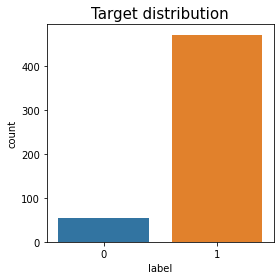

In [34]:
# plotting the distribution of the target column
fig, ax = plt.subplots(figsize=(4,4))
sns.countplot(x=df['label'], ax=ax)
ax.set_title('Target distribution', size = 15)
plt.tight_layout()

df.label.value_counts(ascending=True)

## Step 2 - Tokenize

In [36]:
# nlp pre-processing
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(lemmatize_stemming(token))
    return str(result)

In [39]:
# making a tokens column
df['tokens'] = df.review.map(preprocess)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## Step 3 - Modeling

In [42]:
# define custom functions for machine learning

def crossvalidate_classifier(model, X, y, cm=False):
    
    scores = cross_val_score(model, X, y, scoring='f1_macro', cv=5)
    #scores = cross_val_score(model, X, y, scoring='accuracy', cv=5)
    print("%0.2f f-1 score with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    y_pred = cross_val_predict(model, X, y, cv=5)

    if(cm):
        conf_mat = confusion_matrix(y, y_pred, labels=['fulfillment','other'])
        plot_confusion_matrix(conf_mat, classes = ['fulfillment','other'])
    
def evaluate_classifier(model, X_train, X_test, y_train, y_test):
      
    # ... fit your model here ...
    model.fit(X_train,y_train)

    # Run predict on your tfidf test data to get your predictions
    pred = model.predict(X_test)

    # Calculate your accuracy using the metrics module
    acc_score = metrics.accuracy_score(pred, y_test)
    print("Accuracy Score:   %0.3f" % acc_score)
    
    f1score = metrics.f1_score(pred, y_test, average='macro')
    print("F-1 Score:   %0.3f" % f1score)

    # Calculate the confusion matrices for the tfidf_svc model
    #svc_cm = metrics.confusion_matrix(y_test, pred, labels=['fulfillment','other'])

    # Plot the confusion matrix using the plot_confusion_matrix function
    #plot_confusion_matrix(svc_cm, classes = ['fulfillment','other'], title="Confusion Matrix")
    
    return model

def best_hyperparam(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=5, scoring_fit='f1_score',
                       do_probabilities = False):
    gs = RandomizedSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data, epochs=100)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [43]:
# making the feature and target
X = df['tokens']
y= df['label']

In [46]:
# split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.2, shuffle=True, stratify=y)

In [50]:
# count vectorizer
count_vectorizer = CountVectorizer(stop_words='english', max_df=0.9, min_df=0.05)

# make count train and count test variables
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=0.05)

# make tfidf train and tfidf test variables
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [51]:
print(count_train.shape, tfidf_train.shape)

(420, 91) (420, 91)


In [52]:
print(count_vectorizer.vocabulary_)

{'build': 10, 'like': 41, 'server': 68, 'edit': 23, 'game': 29, 'way': 85, 'want': 84, 'peopl': 58, 'play': 59, 'minecraft': 46, 'great': 31, 'littl': 42, 'onlin': 53, 'worri': 87, 'lot': 43, 'friend': 27, 'stuff': 70, 'swear': 72, 'fun': 28, 'creativ': 18, 'make': 45, 'think': 75, 'updat': 79, 'bad': 4, 'better': 6, 'bite': 7, 'parent': 55, 'kill': 36, 'anim': 3, 'real': 63, 'life': 40, 'let': 39, 'kid': 35, 'pretti': 62, 'age': 0, 'come': 15, 'learn': 38, 'red': 65, 'worth': 88, 'good': 30, 'recommend': 64, 'children': 14, 'time': 76, 'buy': 11, 'world': 86, 'overal': 54, 'easi': 22, 'surviv': 71, 'mode': 48, 'know': 37, 'violenc': 82, 'food': 26, 'year': 89, 'old': 52, 'thing': 74, 'creat': 17, 'amaz': 2, 'chat': 12, 'love': 44, 'blood': 9, 'block': 8, 'monster': 49, 'hit': 33, 'tri': 77, 'hard': 32, 'use': 80, 'multiplay': 50, 'zombi': 90, 'scari': 67, 'educ': 24, 'child': 13, 'allow': 1, 'turn': 78, 'dont': 21, 'start': 69, 'sword': 73, 'best': 5, 'say': 66, 'player': 60, 'need': 

In [53]:
# random forest
# using bag of words
crossvalidate_classifier(RandomForestClassifier(), count_train, y_train)

0.56 f-1 score with a standard deviation of 0.06


In [54]:
# random forest
# using tfidf
crossvalidate_classifier(RandomForestClassifier(), tfidf_train, y_train)

0.51 f-1 score with a standard deviation of 0.05


In [55]:
# gradient boosting
# using bag of words
crossvalidate_classifier(GradientBoostingClassifier(), count_train, y_train)

0.47 f-1 score with a standard deviation of 0.00


In [56]:
# gradient boosting
# using tfidf
crossvalidate_classifier(GradientBoostingClassifier(), tfidf_train, y_train)

0.58 f-1 score with a standard deviation of 0.09


## Conclusion

The Gradient Boosting Classifier using tfidf showed the best results.